In [1]:
import numpy as np
from itertools import cycle
import os
import dask.array as da
import dask.bag as db
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import subprocess
from scipy.ndimage import binary_fill_holes
from importlib import reload
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46749,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:43971,Total threads: 1
Dashboard: /proxy/45445/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:37153,


# What does this package do?

Setting up a regional model in MOM6 is a pain. The goal of this package is that users should spend their debugging time fixing a model that's running and doing weird things, rather than puzzling over a model that won't even start.

In running this notebook, you'll hopefully have a running mom6 regional model. There will still be a lot of fiddling to do with the MOM_input file to make sure that the parameters are set up right for your domain, and you might want to manually edit some of the input files. BUT, this package should help you bypass most of the woes of regridding, encoding and understanding the arcane arts of the mom6 boundary segment files. 



This notebook is designed to showcase where we're up to so far. By the end you should have a running mom6 experiment on the domain of your choice. To make a stable test case:

* Avoid any regions with ice
* Avoid regions near the north pole
* Although the default configuration is meant to be RYF, I've not fixed up the calendar and encoding to run longer than a year just yet
* If you choose to do OM2-01 forcing, set your start date to 1990-01-01 which is what I've got it hardcoded to in step 2 option 2. 

Also hgrid is currently **not** mercator. It's equally spaced lat/long, with square cells at the centre of your domain and decrease in cell area away from equator. The pipeline is modular however, so if another hgrid generation function is written, it will be easy to pass say a gridtype="mercator" to the experiment class.

Input Type | Source
---|---
Surface | JRA (or ERA5 - see end of notebook)
Ocean | GLORYS reanalysis product OR ACCESS OM2-01
Bathymetry | Gebco

# Step 0: Your personal environment variables

In [2]:
scratch = "/scratch/v45/jr5971"
home = "/home/581/jr5971"

# Import local copy of regional library
os.chdir(home+'/reg-scripts')
import regional_library as ml

## If using GLORYs, you'll need an email and password to access their database. make an account here: https://www.copernicus.eu/en/user/login?
pwd = "YOUR COPERNICUS PASSWORD"    
usr = "YOUR COPERNICUS USERNAME"  

# Step 1: Choose our domain, define workspace paths

*JR EDIT: Okay, so this notebook is a follow on from ABs original demo, just with the addition of an interactive GUI to select and save the study domain. Additionally, my focus is on using ACCESS-OM2-01, so this notebook is more geared towards slicing and dicing the ACCESS-output for a regional model, whereas ABs original demo is somewhat more geared to the GLORYS reanalysis ocean forcing.*

#### Import additional libraries for GUI and ACCESS-specific forcing

In [32]:
try:
    import xarray_leaflet
except:
    !pip install xarray_leaflet
    import xarray_leaflet
    
# additional script for access-specific slicing
from access_slicing import open_ryf_global, select_slice, time_rotate
from ipyleaflet import Map, basemaps
import json

### Define experiment, workspace paths and create directories

In [11]:
expt_name = "sharkbay_test"
home_dir = "/home/581/jr5971"
scratch = "/scratch/v45/jr5971"

# set paths
## Directory where you'll run the experiment from
rundir = f'{home_dir}/mom6_rundirs/{expt_name}/'
## Place where all your input files go
inputdir = f'{scratch}/mom6_regional_configs/{expt_name}/'
## Place where temporary files are saved
tmpdir = f'{scratch}/regional_tmp/{expt_name}/'

## Directory where fre tools are stored ***JR NOTE: I don't have access to Angus' home directory :0 ***
# toolpath = "/home/157/ahg157/repos/mom5/src/tools/" ## Compiled tools needed for construction of mask tables
toolpath = "/g/data/v45/jr5971/FRE-NCtools/build3_up_MAXXGRID/tools/"

for i in [rundir,tmpdir,inputdir]:
    if not os.path.exists(i):
        subprocess.run(f"mkdir {i} -p",shell=True)

### Load map and select regional domain interactively!

In [8]:
gridpath = "/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output1077/ocean/ocean_grid.nc"
glob = xr.open_dataset(gridpath)['ht'].rename({'yt_ocean':'y','xt_ocean':'x'})
aus_coords = {'W':-270,'E':-170,'S':-50,'N':0}
ausmap = glob.sel(x=slice(aus_coords['W'],aus_coords['E']), y=slice(aus_coords['S'], aus_coords['N']))
m = Map(center=[-30,160], zoom=3, basemap=basemaps.Esri.WorldImagery)
layer = ausmap.leaflet.plot(m)
ausmap.leaflet.select()
m

Url()

Map(center=[-30, 160], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

The `select()` method above allows to select a region by clicking and dragging a box on the map (first click on the █ button). 
The coordinates of the box are saved into the `tmpdir` for future reference, and the 10th degree bathymetry is plotted below...

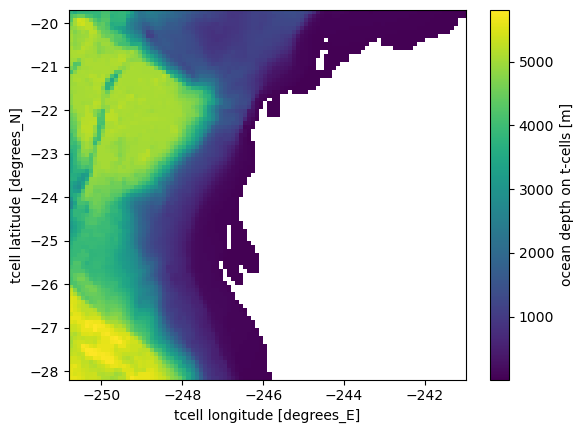

In [9]:
box = ausmap.leaflet.get_selection()
idx = {'W':np.float(box.x[0]), 'E':np.float(box.x[-1]), 
       'S':np.float(box.y[-1]), 'N':np.float(box.y[0])}
# Save domain coordinates for future reference
json_string = json.dumps(idx)
with open(tmpdir+'reg_coords.txt', 'w') as file:
    file.write(json_string)
idx
if box is not None:
    box.plot.imshow()

### Define forcing product, domain extent and date range

In [16]:
forcing_products = ["GLORYS", "ACCESS_RYF", "ACCESS_IAF"]
forcing = forcing_products[1]

# If re-opened notebook, load in domain coordinates from tmpdir
try:
    idx
    print("index already exists")
except: 
    with open(tmpdir+'reg_coords.txt','r') as file:
        idx_string = file.read()
    idx = json.loads(idx_string)
    print('found model coords')

## Choose your coordinates and the name of your experiment
yextent = [idx['S'],idx['N']]  ## latitude
xextent = [idx['W'], idx['E']] ## longitude

# for date, if ACCESS_RYF, daterange always 1990/91. Otherwise set manually (NOTE: could easily put this in expt with "forcing_product" as argument)
if forcing == "ACCESS_RYF":
    daterange = ["1991-01-01 12:00:00", "1991-12-31 12:00:00"]
else:
    daterange = ["2003-01-01 00:00:00", "2003-01-05 00:00:00"] ## 2003 is a good compimise for GLORYs and JRA forcing as they overlap. JRA ends in 2012, GLORYS starts in 1993


index already exists


# Step 2: Prepare ocean forcing data
## ACCESS-OM2-RYF specific
Here, I (JR) have removed sections from ABs demo.ipynb to focus on the ACCESS-forced regional ocean model pipeline. In particular here is the ACCESS-RYF forced model. Below is from `demo.ipynb`:
- *We need to cut out our ocean forcing. The pipeline expects an initial condition and one time-dependent segment per non-land boundary. Naming convention is "east_unprocessed" and "ic_unprocessed" for initial condition*

The first block below is much faster, but will not work if the domain spans the infamous "seam" in access-om2 (-280/+180)? or somewhere around that. It should take somewhere around 10 minutes to save the "unprocessed" netcdf files for each boundary as well as the initial conditions. ***NOTE: Best to use a large number of cpus when performing this step***

In [17]:
%%time
input_vars = ["u","v","salt","temp","eta_t"]
run_year=2170

om2_input = open_ryf_global()[input_vars]
ic = time_rotate(om2_input.sel(time=slice(f'{run_year}-05-01',f'{run_year+1}-04-30'))).isel(time=0)
ic = ic.sel(
    yt_ocean = slice(yextent[0]-0.2, yextent[1]+0.2),
    yu_ocean = slice(yextent[0]-0.2, yextent[1]+0.2),
    xt_ocean = slice(xextent[0]-0.2, xextent[1]+0.2),
    xu_ocean = slice(xextent[0]-0.2, xextent[1]+0.2))
ic.to_netcdf(tmpdir+'/ic_unprocessed.nc')
print('finished saving initial conditions')

for bound in ['east', 'west','north', 'south']:
    edge = select_slice(d=om2_input, borders=[yextent,xextent], boundary=bound)
    print(f'{bound} slice selected')
    edge = time_rotate(edge.sel(time=slice(f'{run_year}-05-01',f'{run_year+1}-04-30'))).chunk({'time':-1})
    print(f'{bound} slice time rotated\nnow saving ...')
    edge.to_netcdf(tmpdir+f'/{bound}_unprocessed.nc')
    print(f'finished saving {bound}ern boundary inputs')

finished saving initial conditions
east slice selected
east slice time rotated
now saving ...
finished saving eastern boundary inputs
west slice selected
west slice time rotated
now saving ...
finished saving western boundary inputs
north slice selected
north slice time rotated
now saving ...
finished saving northern boundary inputs
south slice selected
south slice time rotated
now saving ...
finished saving southern boundary inputs
CPU times: user 1min 25s, sys: 19.2 s, total: 1min 45s
Wall time: 22min 12s


**From here on, everything is pretty much the exact same as the `demo.ipynb` thanks to AB's model-agnostic work with the `regional_library`.**

# Step 3: Make experiment object
This object keeps track of your domain basics, as well as generating the hgrid, vgrid and setting up the folder structures. 

After running you can have a look at your grids by calling `expt.hgrid` and `expt.vgrid`

Plotting vgrid with marker = '.' option lets you see the spacing, or plotting 
```python
np.diff(expt.hgrid.zl).plot(marker = '.')
```
 shows you the vertical spacing profile.

## Modular workflow!

After constructing your expt object, if you don't like my lazy default hgrid and vgrid you can simply modify and overwrite them. However, you'll also need to save them to disk again as I've not automated this just yet. For example:

```python
expt.hgrid = custom_hgrid
expt.hgrid.to_netcdf(f"{inputdir}/hgrid.nc")
```

In [18]:
reload(ml)
expt = ml.experiment(
    xextent,
    yextent,
    daterange,
    0.05,  # Resolution
    75,    # Number of vertical layers
    10,    # Ratio of largest to smallest vertical layer. Select 1 for linear, negative number for higher resolution at bottom
    4500,  # Depth of simulation
    rundir,
    inputdir,
    toolpath
)

i=0, xb1=-250.7500000000, xb2=-241.0500000000, dx=-170.3000000000
NOTE from make_solo_mosaic: there are 0 contacts (align-contact)
congratulation: You have successfully run make_solo_mosaic
FRE TOOLS: Make solo mosaic


CompletedProcess(args=['/g/data/v45/jr5971/FRE-NCtools/build3_up_MAXXGRID/tools/make_solo_mosaic/make_solo_mosaic', '--num_tiles', '1', '--dir', '.', '--mosaic_name', 'ocean_mosaic', '--tile_file', 'hgrid.nc'], returncode=0)


# Step 4: Set up bathymetry

Similarly to ocean forcing, we point our 'bathymetry' method at the location of the file of choice, and pass it a dictionary mapping variable names. This time we don't need to preprocess the topography since it's just a 2D field and easier to deal with. Afterwards you can run `expt.topog` and have a look at your domain. After running this cell, your input directory will contain other topography - adjacent things like the ocean mosaic and mask table too. This defaults to a 10x10 layout which can be updated later.

In [19]:
expt.bathymetry(
    '/g/data/ik11/inputs/GEBCO_2022/GEBCO_2022.nc',
    {"xh":"lon",
     "yh":"lat",
     "elevation":"elevation"}, ## Again this dictionary just maps mom6 variable names to what they are in your topog.
     minimum_layers = 1
    )

 Starting weight generation with these inputs: 
   Source File: bathy_original.nc
   Destination File: topog_raw.nc
   Source variable names: elevation
   Destination variable names: elevation
   Souce Grid has a mask, using missingvalue    1.0000000000000000E+020
   Source File is in GRIDSPEC format with coordinate names lon lat
   Source Grid is a regional grid
   Destination File is in GRIDSPEC format with coordinate names lon lat
   Destination Grid is a regional grid
   Regrid Method: bilinear
   Pole option: NONE

 Completed file regrid successfully.

i=0, xb1=-250.7500000000, xb2=-241.0500000000, dx=-170.3000000000
NOTE from make_solo_mosaic: there are 0 contacts (align-contact)
congratulation: You have successfully run make_solo_mosaic
MAKE SOLO MOSAIC

CompletedProcess(args='/g/data/v45/jr5971/FRE-NCtools/build3_up_MAXXGRID/tools/make_solo_mosaic/make_solo_mosaic --num_tiles 1 --dir . --mosaic_name ocean_mosaic --tile_file hgrid.nc', returncode=0)
cp ./hgrid.nc hgrid.nc 

NOTE

cp: './ocean_mosaic.nc' and 'ocean_mosaic.nc' are the same file
cp: './hgrid.nc' and 'hgrid.nc' are the same file



 ===>NOTE from check_mask: when layout is specified, min_pe and max_pe is set to layout(1)*layout(2)=100

 ===>NOTE from check_mask: Below is the list of command line arguments.

grid_file = ocean_mosaic.nc
model = ocean
topog_file = topog.nc
min_pe = 100
max_pe = 100
layout = 10, 10
halo = 4
sea_level = 0
show_valid_only is not set
nobc = 0

 ===>NOTE from check_mask: End of command line arguments.

 ===>NOTE from check_mask: the grid file is version 2 (solo mosaic grid) grid which contains field gridfiles

==>NOTE from get_boundary_type: x_boundary_type is solid_walls

==>NOTE from get_boundary_type: y_boundary_type is solid_walls

==>NOTE from check_mask: Checking for possible masking:
==>NOTE from check_mask: Assume 4 halo rows
==>NOTE from check_mask: Total domain size is 193, 184

_______________________________________________________________________

NOTE from check_mask: The following is for using model source code with version older than siena_201207,
Possible setting to mas

### Check out your domain:

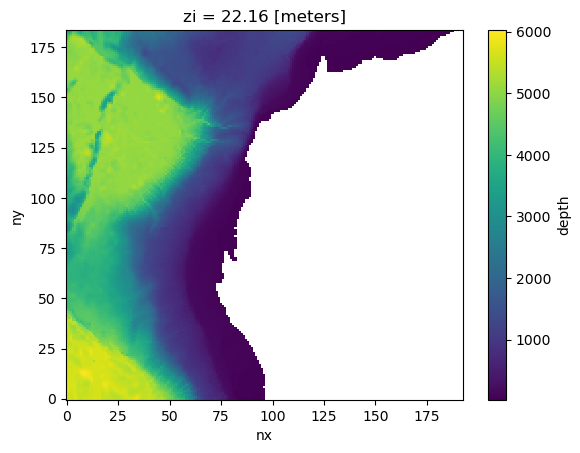

In [20]:
expt.topog.depth.plot()

#  Step 5: Handle the ocean forcing - where the magic happens

This cuts out and interpolates the initial condition as well as all boundaries (unless you don't pass it boundaries).

The dictionary maps the mom6 variable names to what they're called in your ocean input file. Notice how for GLORYs, the horizontal dimensions are x and y, vs xh, yh, xq, yq for ACCESS OM2-01. This is because for an 'A' grid type tracers share the grid with velocities so there's no difference.

If one of your segments is land, you can delete its string from the 'boundaries' list. You'll need to update MOM_input to reflect this though so it knows how many segments to look for, and their orientations. 

### **Note: Only run one of the two cells below according to what forcing you chose!**

In [ ]:
## FOR GLORYS: 
expt.ocean_forcing(
    tmpdir,  ## Path to ocean foring files
    {"time":"time",
     "y":"latitude",
     "x":"longitude",
     "zl":"depth",
     "eta":"zos",
     "u":"uo",
     "v":"vo",
     "tracers":{"salt":"so",
                "temp":"thetao"
                }
    },
    boundaries = ["south","north","west","east"],
    gridtype="A"
)

In [21]:
## FOR ACCESS OM2: 
expt.ocean_forcing(
    tmpdir,  ## Path to ocean foring files
    {"time":"time",
     "yh":"yt_ocean",
     "xh":"xt_ocean",
     "xq":"xu_ocean",
     "yq":"yu_ocean",
     "zl":"st_ocean",
     "eta":"eta_t",
     "u":"u",
     "v":"v",
     "tracers":{"salt":"salt","temp":"temp"}},
    boundaries = ["south","north","west","east"],
    gridtype="B"
    )

INITIAL CONDITIONS
Regridding Velocities...Done.
Regridding Tracers...
Done.
Regridding Free surface...
Saving outputs... done.
BRUSHCUT BOUNDARIES
Processing south...Done.
Processing north...Done.
Processing west...Done.
Processing east...Done.


# Step 6 (optional) Select number of processors 

This is just a wrapper for check_mask FRE tool. Choose the number of processors in the X and Y directions respectively. Having run `.bathymetry()`, you already have one set up for 10x10 by default.

In [22]:
expt.processor_mask((10,10))


 ===>NOTE from check_mask: when layout is specified, min_pe and max_pe is set to layout(1)*layout(2)=100

 ===>NOTE from check_mask: Below is the list of command line arguments.

grid_file = ocean_mosaic.nc
model = ocean
topog_file = topog.nc
min_pe = 100
max_pe = 100
layout = 10, 10
halo = 4
sea_level = 0
show_valid_only is not set
nobc = 0

 ===>NOTE from check_mask: End of command line arguments.

 ===>NOTE from check_mask: the grid file is version 2 (solo mosaic grid) grid which contains field gridfiles

==>NOTE from get_boundary_type: x_boundary_type is solid_walls

==>NOTE from get_boundary_type: y_boundary_type is solid_walls

==>NOTE from check_mask: Checking for possible masking:
==>NOTE from check_mask: Assume 4 halo rows
==>NOTE from check_mask: Total domain size is 193, 184

_______________________________________________________________________

NOTE from check_mask: The following is for using model source code with version older than siena_201207,
Possible setting to mas

## Step 7 Regrid the runoff 

 This step will be removed in a future update when this functionality is added to rest of pipeline. Currently it calls a function from the legacy regional_model_scripts file. Just execute cell to give your domain runoff from JRA in 1991. Rivers do the same thing every year right?


In [23]:
from regional_model_scripts import regrid_runoff
runoff_path = "/g/data/ik11/inputs/JRA-55/RYF/v1-3/RYF.runoff_all.1990_1991.nc" ## Can change to match your year

regrid_runoff(inputdir + "ocean_mask.nc",
    inputdir + "hgrid.nc",
    runoff_path,
    inputdir + "runoff_regrid.nc",
    # np.array(xextent) - np.array([180,180]),
    xextent,
    yextent)

<xarray.Dataset>
Dimensions:    (latitude: 34, longitude: 39, time: 365)
Coordinates:
  * latitude   (latitude) float64 -28.12 -27.88 -27.62 ... -20.38 -20.12 -19.88
  * longitude  (longitude) float64 109.4 109.6 109.9 110.1 ... 118.4 118.6 118.9
  * time       (time) object 1900-01-01 00:00:00 ... 1900-12-31 00:00:00
Data variables:
    friver     (time, latitude, longitude) float32 ...
Attributes:
    title:        River runoff into the ocean of JRA55-do
    institution:  JMA Meteorological Research Institute
    comment:      River routing model CaMaFlood forced by JRA-55 runoff from ...
    version:      v1.1
    fill_value:   Fill value is -9.99e33


# Step 8: Modify the default input directory to make a (hopefully) runnable configuration out of the box

This cell just copies a default run directory and modifies it to match your configuration.



In [26]:
# define project for config.yaml: e.g., x77 | v45 |...
project = "v45"
if project == "v45":
    mom6_exe = "/g/data/v45/mom/symmetric_FMS2-e7d09b7"
elif project == "x77":
    mom6_exe = "/g/data/x77/ahg157/exes/MOM6_SIS2/symmetric_FMS2-e7d09b7"
else:
    pass

In [31]:
subprocess.run(f"cp default_rundir/jra_surface/* {rundir} -r",shell = True)
# subprocess.run(f"cp default_rundir/era5_surface/* {rundir} -r",shell = True)
subprocess.run(f"ln -s {inputdir} {rundir}/inputdir",shell=True)

hgrid = xr.open_dataset(f"{inputdir}/hgrid.nc")

## Get mask table information
ncpus = 10
mask_table = None
for i in os.listdir(f"{inputdir}"):
    if "mask_table" in i:
        mask_table = i
        a = mask_table.split(".")[1]
        b = mask_table.split(".")[2].split("x")
        ncpus = int(b[0]) * int(b[1]) - int(a)


## Modify MOM_input
inputfile = open(f"{rundir}/MOM_input",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "MASKTABLE" in lines[i]:
        if mask_table != None:
            lines[i] = f'MASKTABLE = "{mask_table}"\n'
        else:
            lines[i] = "# MASKTABLE = no mask table"
    if "LAYOUT =" in lines[i] and "IO" not in lines[i]:
        lines[i] = f'LAYOUT = {expt.layout[1]},{expt.layout[0]}\n'

    if "NIGLOBAL" in lines[i]: 
        # lines[i] = f"NIGLOBAL = {str(x_indices_centre[1] - x_indices_centre[0])}\n"
        lines[i] = f"NIGLOBAL = {hgrid.nx.shape[0]//2}\n"

        
    if "NJGLOBAL" in lines[i]:
        # lines[i] = f"NJGLOBAL = {str(y_indices_centre[1] - y_indices_centre[0])}\n"
        lines[i] = f"NJGLOBAL = {hgrid.ny.shape[0]//2}\n"

        
inputfile = open(f"{rundir}/MOM_input",'w')

inputfile.writelines(lines)
inputfile.close()

## Modify SIS_input
inputfile = open(f"{rundir}/SIS_input",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "MASKTABLE" in lines[i]:
        lines[i] = f'MASKTABLE = "{mask_table}"\n'
    if "NIGLOBAL" in lines[i]:
        # lines[i] = f"NIGLOBAL = {str(x_indices_centre[1] - x_indices_centre[0])}\n"
        lines[i] = f"NIGLOBAL = {hgrid.nx.shape[0]//2}\n"
    if "LAYOUT =" in lines[i] and "IO" not in lines[i]:
        lines[i] = f'LAYOUT = {expt.layout[1]},{expt.layout[0]}\n'
    if "NJGLOBAL" in lines[i]:
        # lines[i] = f"NJGLOBAL = {str(y_indices_centre[1] - y_indices_centre[0])}\n"
        lines[i] = f"NJGLOBAL = {hgrid.ny.shape[0]//2}\n"
        
inputfile = open(f"{rundir}/SIS_input",'w')
inputfile.writelines(lines)
inputfile.close()

## Modify config.yaml 
inputfile = open(f"{rundir}/config.yaml",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "project" in lines[i]:
        lines[i] = f'project: {project}\n'
    if "shortpath" in lines[i]:
        lines[i] = f"shortpath: /scratch/{project}"
    if "ncpus" in lines[i]:
        lines[i] = f'ncpus: {str(ncpus)}\n'
    if "jobname" in lines[i]:
        lines[i] = f"jobname: mom6_{expt_name}\n"
    if "input:" in lines[i]:
        lines[i + 1] = f"    - {inputdir}\n"
    if "exe:" in lines[i]:
        lines[i:i+3] = f"exe: {mom6_exe}\n"
    if "storage:" in lines[i]:
        lines[i+1:i+5] = f"  gdata:\n    - ua8\n    - {project}\n    - ik11"

inputfile = open(f"{rundir}/config.yaml",'w')
inputfile.writelines(lines)
inputfile.close()


# Modify input.nml 
inputfile = open(f"{rundir}/input.nml",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "current_date" in lines[i]:
        tmp = daterange[0].split(" ")[0].split("-")
        lines[i] = f"{lines[i].split(' = ')[0]} = {int(tmp[0])},{int(tmp[1])},{int(tmp[2])},0,0,0,\n"

 
inputfile = open(f"{rundir}/input.nml",'w')
inputfile.writelines(lines)
inputfile.close()


ln: failed to create symbolic link '/home/581/jr5971/mom6_rundirs/sharkbay_test//inputdir/sharkbay_test': File exists


# BONUS! Want to use ERA5 surface forcing instead?

This is WIP and not well tested but thought I'd include it

## SET UP ERA5 forcing:
Here we take the ERA forcing as it already exists on Gadi. For NCI users, you need access to the rt group. ERA5 - specific functions provided cut out the region of interest and fix up the metadata ready for MOM6.

For this example, we are forcing for the entire year of 2015 so we just generate a single forcing file with 2015's data.

Below is a table showing ERA5 characteristics and what needs to be done to sort it out
### Required ERA data:
Name | ERA filename | era variable name | notes
---|---|---|---
Surface Pressure | sp | sp | Pa :heavy_check_mark:
Surface Temperature | 2t | t2m | K :heavy_check_mark:
Meridional Wind | 10v | v10 | m/s :heavy_check_mark:
Zonal Wind | 10u | u10 | m/s :heavy_check_mark:
Specific Humidity | na | na | kg/kg, calculated from dewpoint temperature
Dewpoint Temperature | 2d | d2m | K


We can calculate specific humidity $q$ from dewpoint temperature $T_d$ and surface pressure $P$ via saturation vapour pressure $P_v$.

$\large P_v = 10^{8.07131 - \frac{1730.63}{233.426 + T}} \frac{101325}{760} $ Pascals

$\large q = 0.001 * 0.622  \frac{P_v}{P}$ 

In [ ]:
erapath = "/g/data/rt52/era5/single-levels/reanalysis"

## Firstly just open all raw data
rawdata = {}
for fname , vname in zip(["2t","10u","10v","sp","2d"] , ["t2m","u10","v10","sp","d2m"]):

    ## Cut out this variable to our domain size
    rawdata[fname] = ml.nicer_slicer(
        xr.open_mfdataset(f"{erapath}/{fname}/{daterange[0].split('-')[0]}/{fname}*",decode_times = False,chunks = {"longitude":100,"latitude":100}),
        xextent,
        "longitude"
    ).sel(
        latitude = slice(yextent[1],yextent[0]) ## This is because ERA5 has latitude in decreasing order (??)
    )

    ## Now fix up the latitude and time dimensions

    rawdata[fname] = rawdata[fname].isel(
        latitude = slice(None,None,-1) ## Flip latitude        
        ).assign_coords(
        time = np.arange(0,rawdata[fname].time.shape[0],dtype=float) ## Set the zero date of forcing to start of run
        )
    

    

    rawdata[fname].time.attrs = {"calendar":"julian","units":f"hours since {daterange[0]}"} ## Fix up calendar to match

    if fname == "2d":
        ## Calculate specific humidity from dewpoint temperature 
        q = xr.Dataset(
            data_vars= {
                "q": (0.622 / rawdata["sp"]["sp"]) * (10**(8.07131 - 1730.63 / (233.426 + rawdata["2d"]["d2m"] - 273.15) )) * 101325 / 760
                }

        )
        q.q.attrs = {"long_name":"Specific Humidity","units": "kg/kg"}
        q.to_netcdf(f"{inputdir}/forcing/q_ERA5",unlimited_dims = "time",encoding = {"q":{"dtype":"double"}})
    else:
        rawdata[fname].to_netcdf(f"{inputdir}/forcing/{fname}_ERA5",unlimited_dims = "time",encoding = {vname:{"dtype":"double"}})


## Update the data table to match:

subprocess.run(f"cp default_rundir/era5_surface/data_table {rundir}/data_table",shell = True)